In [1]:
import numpy as np 


import sys
import os

import jax
import jax.numpy as jnp 

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


from kltpicker_3d.alt_least_squares import alternating_least_squares_solver
from kltpicker_3d.tests.exp_spectrum import *
from kltpicker_3d.tests.gaussian_spectrum import * 
from kltpicker_3d.tests.rpsd_test_data import generate_gaussian_rpsd_data
from kltpicker_3d.tomogram import factorize_RPSD
from kltpicker_3d.utils import * 

import scipy
from scipy.special import legendre
import scipy.integrate as integrate

import sys
import os
jax.config.update("jax_platform_name", "cpu")

# plt.style.use('ggplot')
jax.default_backend()   

plt.rcParams.update({
    "axes.grid": True,
    "grid.alpha": 0.5
})

In [4]:
vect_spectrum_estimation = jax.vmap(estimate_isotropic_powerspectrum_tensor,
                                    in_axes=(0,None))

The following is an experiment in which we use the following isotropic PSD: $$S_T(\omega)= e^{-Tx}$$

It's a simple and convinent set of functions that we can utilize to check the dependence on the PSD bandlimit. For numerical reasons we find the PSD to be supported on $[0, -\log(1e-15)/T]$.

Note that $-\log(1e-15) \sim 34$ hence we took multiples of 30 to look at bandlimits of range $(0,1+\epsilon)$.

In [138]:
K = 200
N = 32 
M = 2*N - 1 


Ts = 30*np.arange(1,7)
experiments = []
true_psds = []
for T in Ts:
    grid = np.arange(-(N-1),N) 
    i,j,k  = np.meshgrid(grid,grid,grid) 
    omega_r = np.sqrt(i ** 2 + j ** 2 + k ** 2)
    #H = 1/(1 + (omega_r/T)**2)
    k  = -np.log(1e-15)/T
    H = np.exp(-k*omega_r)
    C = M ** 3 / H.sum()
    normalized_H = np.fft.ifftshift(np.sqrt(H * C))

    samples = np.zeros((K,N,N,N))
    alphas = np.random.beta(2,5,size=(K)) 
    for k in range(K):
        noise = np.random.normal(size=(M,M,M)) 
        additive_noise = np.random.normal(scale=0.1,size=(M,M,M))
        sample = np.fft.ifftn(normalized_H*np.fft.fftn(noise))
        sample = alphas[k]*sample + additive_noise
        samples[k] = sample[:N,:N,:N]

    samples = samples.real
    experiments.append(samples) 
    true_psds.append(H)

/tmp/ipykernel_1772155/209252345.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  samples[k] = sample[:N,:N,:N]


In [127]:
uniform_points, bins = generate_uniform_radial_sampling_points(N)
max_d = int(np.floor(N/3))  

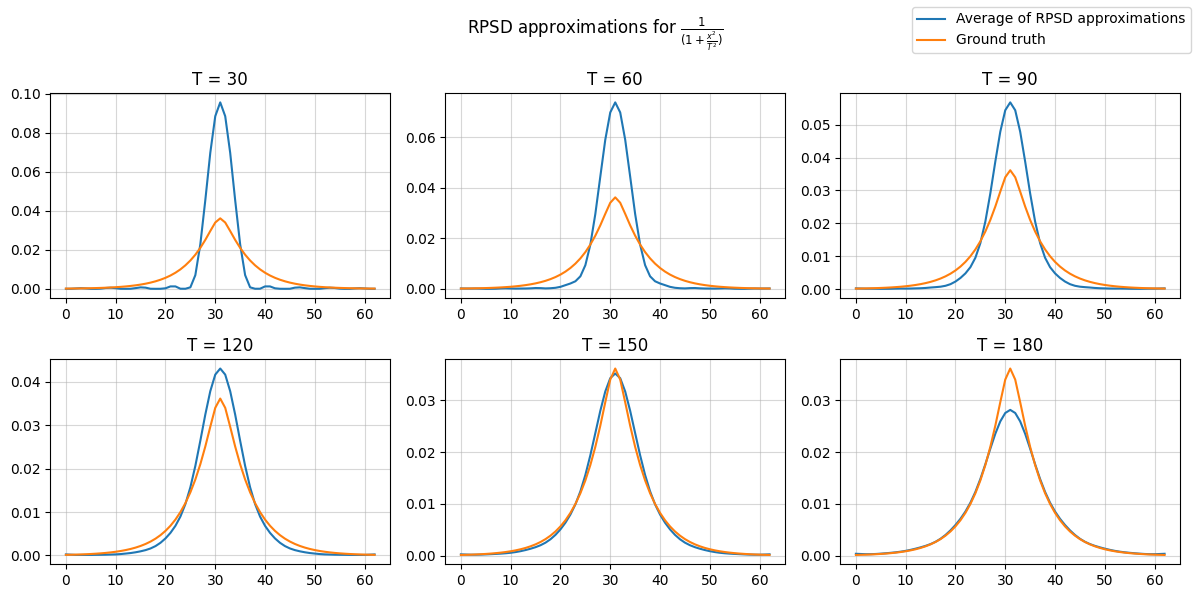

In [139]:
fig,ax = plt.subplots(2,3,figsize=(12,6))

psds = []

for i,T in enumerate(Ts):
    samples = experiments[i] - jnp.mean(experiments[i], axis=(1,2,3)).reshape(-1,1,1,1)
    psd = vect_spectrum_estimation(samples,max_d)  
    psds.append(psd)
    
    S = H / np.linalg.norm(H)
    avg_psd = np.mean(psd,axis=0)
    avg_psd /= np.linalg.norm(avg_psd)
    
    ax[i//3,i%3].set_title(f"T = {T}")
    ax[i//3,i%3].plot(avg_psd[N,N,:], label='Average of RPSD approximations')
    ax[i//3,i%3].plot(S[N,N,:], label='Ground truth')

fig.suptitle(r"RPSD approximations for $\frac{1}{(1+\frac{x^2}{T^2})}$")
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels)
fig.tight_layout()

In [9]:
def trigonometric_interpolation(x,y,z):
    n = x.shape[0]
    
    scale = (x[1] - x[0]) * n / 2 
    x_scaled = (x / scale) * jnp.pi / 2 
    z_scaled = (z / scale) * jnp.pi / 2

    delta = z_scaled[:, None] - x_scaled[None, :]
    # We take n to be only even 
    M = jnp.sin(n*delta) / (n *jnp.sin(delta))
    #if n % 2 == 0:
    #    M = np.sin(n*delta) / (n *jnp.sin(delta))
    #else:
    #    M = np.sin(n*delta)/ (n*jnp.tan(delta))
    M = M.at[jnp.isclose(delta,0)].set(1.0)

    p = M @ y 
    return p

In [10]:
X,w = scipy.special.roots_legendre(150)
X_scaled = 0.5*X + 0.5

In [11]:
rpsds = []

for i in range(Ts.shape[0]):
    rblocks = np.array([radial_average(psds[i][k], bins, N) for k in range(K)])
    factorization = alternating_least_squares_solver(rblocks,500,1e-4)

    particle_psd = factorization.gamma
    noise_psd = factorization.v
    
    # H = true_psds[i]
    # H /= np.linalg.norm(H)
    # true_rpsd = radial_average(H,bins,N)
    # true_rpsd /= np.linalg.norm(true_rpsd)

    noise_psd /= np.linalg.norm(noise_psd)
    particle_psd /= np.linalg.norm(particle_psd)
    Gx = trigonometric_interpolation(uniform_points, particle_psd, X_scaled)
    Gx /= np.linalg.norm(Gx)
    rpsds.append(Gx)

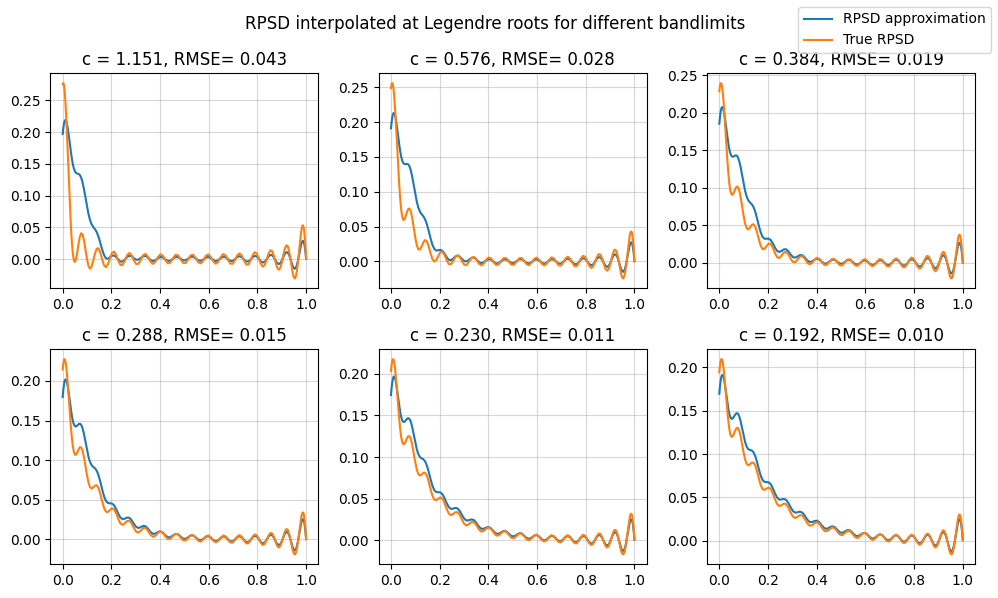

In [40]:
fig,ax = plt.subplots(2,3,figsize=(10,6))

for i,T in enumerate(Ts):
    H = true_psds[i]
    H /= np.linalg.norm(H)
    true_rpsd = radial_average(H,bins,N)
    true_rpsd /= np.linalg.norm(true_rpsd)

    Gx_true = trigonometric_interpolation(uniform_points, true_rpsd, X_scaled)
    Gx_true /= np.linalg.norm(Gx_true)

    rmse = np.sqrt(np.mean((Gx_true - rpsds[i])**2))
    c = -np.log(1e-15)/T
    ax[i//3,i%3].set_title(f"c = {c:.3f}, RMSE= {rmse:.3f}")
    ax[i//3,i%3].plot(X_scaled,rpsds[i], label='RPSD approximation')
    ax[i//3,i%3].plot(X_scaled, Gx_true, label='True RPSD')


plt.suptitle("RPSD interpolated at Legendre roots for different bandlimits")
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels)
fig.tight_layout()

In [43]:
from scipy.special import spherical_jn 


def fredholm_solver(Gx,N,a,c,K=150):
    def Hn(x):
        return 2*np.pi * (2*(1j**N) * spherical_jn(N,x))

    X,w = scipy.special.roots_legendre(K)
    inner_rho = (c/2)*X + c/2
    outer_rho = (a/2)*X + a/2

    vv = np.array([[Hn(inner_rho[i]*inner_rho[j]) for j in range(K)] for i in range(K)])

    def psi_even(i,j):
        return c/2 * np.sum(w * vv[j,:] * vv[i,:] * Gx * (inner_rho)**2)
    
    def psi_odd(i,j):
        return c/2 * np.sum(w * (-vv[j,:]) * vv[i,:] * Gx * (inner_rho)**2)

    psi = psi_even if N % 2 == 0 else psi_odd
    H = np.array([[psi(j,i) for j in range(K)] for i in range(K)])
    W = a/2 * np.diag(w*(outer_rho)**2)
    
    # Make H symmetric for stable solution
    A = np.sqrt(W) @ H @ np.sqrt(W)    
    eigvals, Y = np.linalg.eigh(A)
    R = np.linalg.solve(np.sqrt(W), Y) 

    eigvals = eigvals[::-1]
    eigfuncs = R[:,::-1]
    return eigvals, eigfuncs, W

In [44]:
order = 1 
eigvals = []
for i,T in enumerate(Ts):
    temp = []
    c = -np.log(1e-15)/T
    for order in np.arange(5):
        eigvals_T, _, _ = fredholm_solver(rpsds[i],order,1,c)
        temp.append(eigvals_T)

    eigvals.append(temp)

In [57]:
eigs = np.sort(np.stack(eigvals).reshape(6,-1),axis=1)

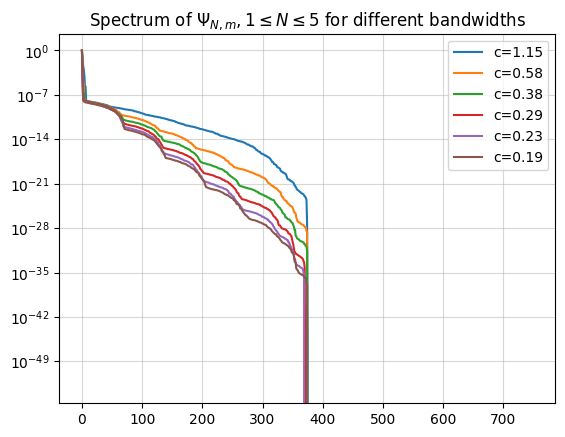

In [ ]:
palette = plt.cm.plasma(np.linspace(0, 1, len(Ts)))

for i,T in enumerate(Ts):
    eigval = eigs[i]/np.sum(eigs[i])
    plt.plot(eigval[::-1],label=f'c={-np.log(1e-15)/T:.2f}')

plt.title("Spectrum of $\Psi_{N,m}, 1\leq N \leq 5$ for different bandwidths")
plt.yscale('log')
plt.legend();

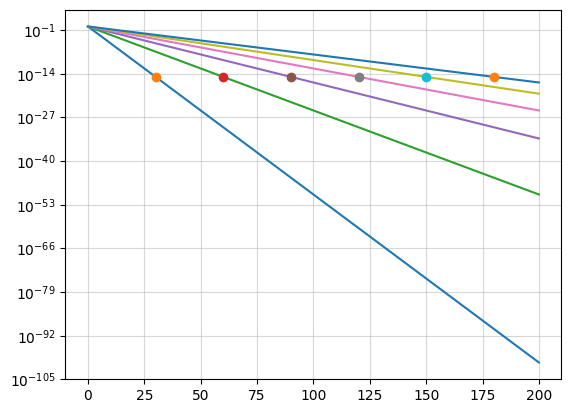

In [ ]:
Ts = 30*np.arange(1,7)

for T in Ts:
    k  = -np.log(1e-15)/T
    xx = np.linspace(0,200,100)
    plt.plot(xx,np.exp(-k*xx))
    plt.plot(T, np.exp(-k*T),'o')

plt.yscale('log')